## Import libraries

In [1]:
import math
import random
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

## Define variables

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 32
EMBED_DIM = 64
ATTENTION_HEADS = 4
BATCH_SIZE = 12
EPOCHS = 10
LR = 3e-4
TEMPERATURE = 0.07

## Synthetic dataset properties

In [3]:
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray']
shapes = ['square', 'circle', 'triangle']
positions = ['left', 'center', 'right', 'top', 'bottom', 'top-left', 'top-right', 'bottom-left', 'bottom-right']

## Drawing image shapes

In [4]:
def draw_sample(color, shape, position, img_size=IMG_SIZE):
    img = Image.new('RGB', (img_size, img_size), 'white')
    draw = ImageDraw.Draw(img)
    
    margin = 6
    h = w = img_size - 2 * margin
    
    # Calculate x coordinates
    if 'left' in position:
        x0 = margin
        x1 = margin + w // 2
    elif 'top-left' in position:
        x0 = margin
        x1 = margin + w // 2
    elif 'bottom-left' in position:
        x0 = margin
        x1 = margin + w // 2
    elif 'right' in position:
        x0 = margin + w // 2
        x1 = img_size - margin
    elif 'top-right' in position:
        x0 = margin + w // 2
        x1 = img_size - margin
    elif 'bottom-right' in position:
        x0 = margin + w // 2
        x1 = img_size - margin
    else: # Center or vertical positions
        x0 = margin + w // 4
        x1 = margin + 3 * w // 4
        
     # Calculate y coordinates
    if 'top' in position:
        y0 = margin
        y1 = margin + h // 2
    elif 'top-left' in position:
        y0 = margin
        y1 = margin + h //  2
    elif 'top-right' in position:
        y0 = margin
        y1 = margin + h // 2
    elif 'bottom' in position:
        y0 = margin + h // 2
        y1 = img_size - margin
    elif 'bottom-left' in position:
        y0 = margin + h // 2
        y1 = img_size - margin
    elif 'bottom-right' in position:
        y0 = margin + h // 2
        y1 = img_size - margin
    else: # Center or horizontal positions
        y0 = margin + h // 4
        y1 = margin + 3 * h // 4
        
    if shape=='square':
        draw.rectangle([x0, y0, x1, y1], fill=color, outline='black')
    elif shape=='circle':
        draw.ellipse([x0, y0, x1, y1], fill=color, outline='black')
    else: # triangle
        draw.polygon([(x0+(x1-x0)//2, y0), (x0, y1), (x1, y1)], fill=color, outline='black')
        
    return img

## Class for building our dataset

In [5]:
class ShapeDataset(Dataset):
    def __init__(self):
        self.images = []
        self.captions = []
        
        for c in colors:
            for s in shapes:
                for p in positions:
                    img = draw_sample(c, s, p)
                    cap = f"{c} {s} {p}"
                    
                    self.images.append(torch.from_numpy(np.asarray(img)).permute(2,0,1).float()/255.0)
                    self.captions.append(cap)
                    
        self.vocab, self.word2idx = self.build_vocab(self.captions)
                    
    def build_vocab(self, texts):
        words = sorted({w for t in texts for w in t.split()})
        vocab = ['[CLS]'] + words
        w2i = {w:i for i, w in enumerate(vocab)}
        return vocab, w2i
    
    def encode_text(self, text):
        toks = [self.word2idx['[CLS]']] + [self.word2idx[w] for w in text.split()]
        return torch.tensor(toks, dtype=torch.long)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        return self.images[i], self.encode_text(self.captions[i]), self.captions[i]
        
# Craete the full dataset
full_dataset = ShapeDataset()
VOCAB_SIZE = len(full_dataset.vocab)
print(VOCAB_SIZE)
print(full_dataset.vocab)

22
['[CLS]', 'blue', 'bottom', 'bottom-left', 'bottom-right', 'brown', 'center', 'circle', 'gray', 'green', 'left', 'orange', 'pink', 'purple', 'red', 'right', 'square', 'top', 'top-left', 'top-right', 'triangle', 'yellow']


/tmp/ipykernel_3226477/3130941873.py:12: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  self.images.append(torch.from_numpy(np.asarray(img)).permute(2,0,1).float()/255.0)


## Train-val data creation

In [6]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

## Dataloader

In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Display sample data points

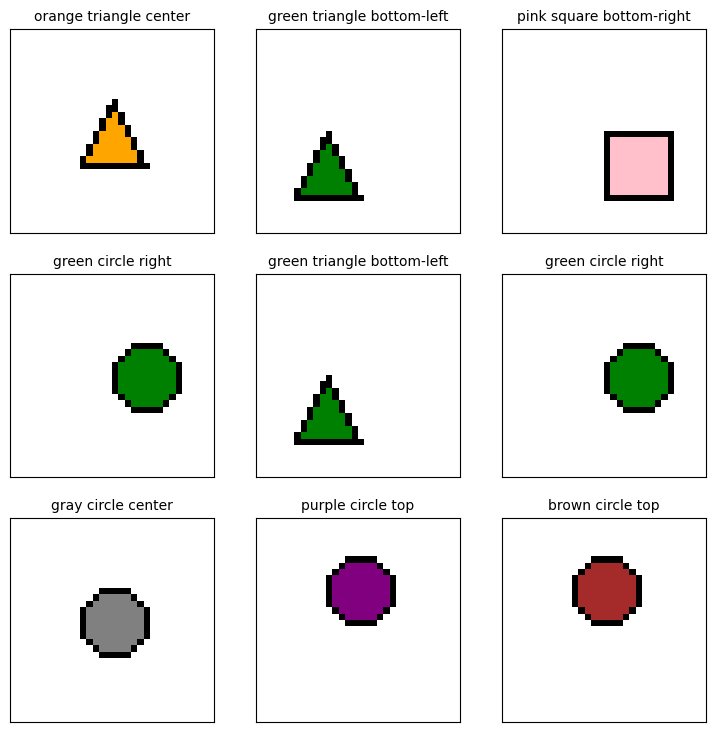

In [73]:
imgs, _, caps = next(iter(train_loader))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
axes = axes.flatten()

for ax in axes:
    rand_id = random.randint(0, len(imgs)-1)
    img = imgs[rand_id].permute(1, 2, 0).numpy()
    cap = caps[rand_id]
    ax.imshow(img)
    
    ax.set_title(cap, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## Image Encoder

In [75]:
class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=EMBED_DIM):
        super().__init__()
        self.convolutions = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        self.projection = nn.Linear(256, embed_dim)
        self.layernorm1 = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        x = self.convolutions(x)
        x = x.mean(dim=[2, 3])
        x = self.projection(x)
        x = F.normalize(self.layernorm1(x), dim=-1)
        return x

## Text Encoder